# Universe Selection
---

Selecting the product space in which an algorithm trades can be as important as, if not more than, the strategy itself. In this lecture, we will walk through the basics of constructing a universe and introduce new tools that allow you to accomplish these often tricky and subtle calculations with ease.

## What is a Universe?

On a high level, universe selection is the process of choosing the pool of securities upon which your algorithm will trade. For example, an algorithm designed to play with the characteristics of a universe consisting of technology equities may perform exceptionally well in that universe with the tradeoff of falling flat in other sectors. Experimenting with different universes by tweaking their components is an essential part of developing a trading strategy.

Using Pipeline, we have access to around 8300 securities to choose from each day. However, the securities within this basket are markedly different. Some are different asset classes, some belong to different sectors and super-sectors, some employ different business models, some practice different management styles, and so on. By defining a universe, a trader can narrow in on securities with one or more of these attributes in order to craft a strategy that is most effective for that subset of the population.

Without a properly-constructed universe, your algorithm may be exposed to risks that you just aren't aware of. For example, it could be possible that your universe selection methodology only selects a stock basket whose constituents do not trade very often. Let's say that your algorithm wants to place an order of 100,000 shares for a company that only trades 1,000 on a given day. The inability to fill this order or others might prevent you from achieving the optimal weights for your portfolio, thereby undermining your strategy. These risks can be  controlled for by careful and thoughtful universe selection.

Below is an example implementation of a universe that limits Pipeline output to the 500 securities with the largest revenue each day. This can be seen as a naive implementation of the Fortune500.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
universe = Fundamentals.total_revenue.latest.top(500)

pipe = Pipeline(
    columns={
        'Revenue': Fundamentals.total_revenue.latest
    },
    screen=universe
)
res = run_pipeline(pipe, '2016-01-01', '2016-01-01')
print "There are %d assets in this universe." % len(res.index.levels[1])

res.head(10) # print 10 constituents 

There are 500 assets in this universe.


Revenue
2016-01-04 00:00:00+00:00 Equity(2 [ARNC])      5.573000e+09
                          Equity(24 [AAPL])     5.150100e+10
                          Equity(25 [ARNC_PR])  5.573000e+09
                          Equity(62 [ABT])      5.150000e+09
                          Equity(128 [ADM])     1.656500e+10
                          Equity(161 [AEP])     4.432000e+09
                          Equity(166 [AES])     3.721000e+09
                          Equity(168 [AET])     1.495300e+10
                          Equity(185 [AFL])     5.040000e+09
                          Equity(239 [AIG])     1.282200e+10

This is a good start, but again, it is a very naive universe. Normally, high revenue is a characteristic of a healthy, thriving company, but there are many other things that play into the construction of a good universe. While this idea has a reasonable economic basis, more analysis has to be conducted to determine the efficacy of this universe. There may be more subtle things occurring independently of the revenue of its constituent companies.

For the rest of this notebook, we will design our own universe, profile it and check its performance. Let's create the Lectures500!

##Lectures500

###Sector Exposure

If I create a universe that only looks at equities in the technology sector, my algorithm will have an extreme sector bias. Companies in the same industry sector are affected by similar macroeconomic trends and therefore their performance tends to be correlated. In the case of particular strategies, we may find the benefits of working exclusively within a particular sector greater than the downside risks, but this is not suitable for creating a general-purpose, quality universe.

Let's have a look at the sector breakdown of the Lectures500.

In [3]:
# Rename our universe to Lectures500
Lectures500 = universe

SECTOR_CODE_NAMES = {
    Sector.BASIC_MATERIALS: 'Basic Materials',
    Sector.CONSUMER_CYCLICAL: 'Consumer Cyclical',
    Sector.FINANCIAL_SERVICES: 'Financial Services',
    Sector.REAL_ESTATE: 'Real Estate',
    Sector.CONSUMER_DEFENSIVE: 'Consumer Defensive',
    Sector.HEALTHCARE: 'Healthcare',
    Sector.UTILITIES: 'Utilities',
    Sector.COMMUNICATION_SERVICES: 'Communication Services',
    Sector.ENERGY: 'Energy',
    Sector.INDUSTRIALS: 'Industrials',
    Sector.TECHNOLOGY: 'Technology',
    -1 : 'Misc'
}

def get_sector_codes(day, universe):
    pipe = Pipeline(columns={'Sector': Sector()}, screen=universe)
    # Drop the datetime level of the index, since we only have one day of data 
    return run_pipeline(pipe, day, day).reset_index(level=0, drop=True)


def calculate_sector_counts(sectors):
    counts = (sectors.groupby('Sector').size())

    # Replace numeric sector codes with human-friendly names
    counts.index = counts.index.map(lambda code: SECTOR_CODE_NAMES[code])
    return counts

lectures500_sectors = get_sector_codes('2016-01-04', Lectures500)
lectures500_counts = calculate_sector_counts(lectures500_sectors)

In [4]:
def plot_sector_counts(sector_counts):
    
    bar = plt.subplot2grid((5,5), (0,0), rowspan=2, colspan=5)
    pie = plt.subplot2grid((5,5), (2,0), rowspan=3, colspan=5)
    
    # Bar chart
    sector_counts.plot(
        kind='bar',
        color='b',
        rot=30,
        ax=bar,
    )
    
    bar.set_title('Sector Exposure - Counts')
    
    # Pie chart
    sector_counts.plot(
        kind='pie', 
        colormap='Set3', 
        autopct='%.2f %%',
        fontsize=12,
        ax=pie,
    )
    pie.set_ylabel('')  # This overwrites default ylabel, which is None :(
    pie.set_title('Sector Exposure - Proportions')
    
    plt.tight_layout();

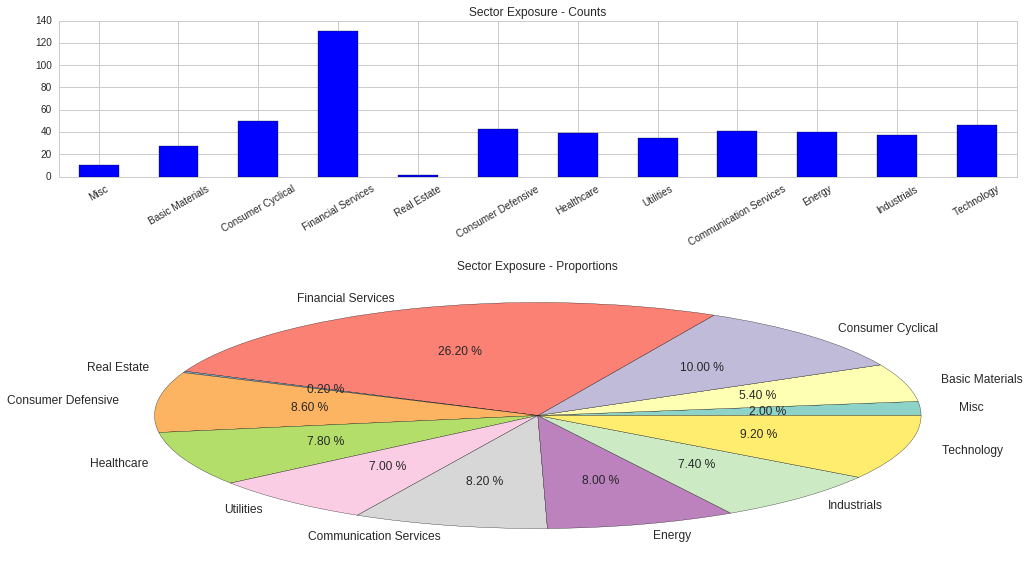

In [5]:
plot_sector_counts(lectures500_counts)

From the above plots it is clear that there is a mild sector bias towards the financial services industry. Any big events that affect companies in this sector will have a large effect on this universe and any algorithm that uses it.

One option is to equal-weight the sectors, so that equities from each industry sector make up an identical proportion of the final universe. This, however, comes with its own disadvantages. In a sector-equal Lectures500, the universe would include some lower-revenue real estate equities at the expense of higher-revenue financial services equities.

###Turnover

Another thing to consider when designing a universe is the rate at which the universe changes. Turnover is a way of measuring this rate of change. Turnover is defined as the number of equities to enter or exit the universe in a particular time window. 

Let us imagine a universe with a turnover of 0. This universe would be completely unchanged by market movements. Moreover, stocks inappropriate for the universe would never be removed and stocks that should be included will never enter.

Conversely, imagine a universe that changes every one of its constituents every day. An algorithm built on this universe will be forced to sell its entire portfolio every day. This incurs transaction costs which erode returns.

When creating a universe, there is an inherent tradeoff between stagnation and sensitivity to the market.

Let's have a look at the turnover for the Lectures500!

In [6]:
res = run_pipeline(Pipeline(columns={'Lectures500' : Lectures500}), '2015-01-01', '2016-01-01')
res = res.unstack().fillna(False)

def calculate_daily_turnover(unstacked):
    return (unstacked
            .diff()        # Get True/False showing where values changed from previous day.
            .iloc[1:]      # Drop first row, which is meaningless after diff().
            .astype(bool)  # diff() coerces from bool -> object :(.  Undo that.
            .groupby(axis=1, level=0)  
            .sum())        # Group by universe and count number of True values in each row.

def plot_daily_turnover(unstacked):
    
    # Calculate locations where the inclusion state of an asset changed.
    turnover = calculate_daily_turnover(unstacked)
    
    # Write the data to an axis.
    ax = turnover.plot(figsize=(14, 8))
    
    # Add style to the axis.
    ax.grid(False)
    ax.set_title('Changes per Day')
    ax.set_ylabel('Number of Added or Removed Assets')
    

def print_daily_turnover_stats(unstacked):
    turnover = calculate_daily_turnover(unstacked)
    print(turnover.describe().loc[['mean', 'std', '25%', '50%', '75%', 'min', 'max']])

      Lectures500
mean     1.761905
std      3.402433
25%      0.000000
50%      0.000000
75%      2.000000
min      0.000000
max     30.000000


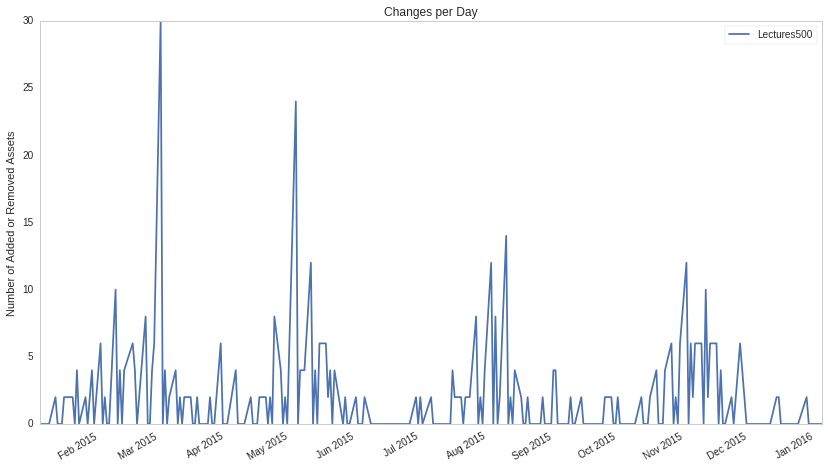

In [7]:
plot_daily_turnover(res)
print_daily_turnover_stats(res)

#### Smoothing

A good way to reduce turnover is through smoothing functions. Smoothing is the process of taking noisy data and aggregating it in order to analyze its underlying trends. When applied to universe selection, a good smoothing function prevents equities at the universe boundary from entering and exiting frequently.

One example of a potential smoothing function is a filter that finds equities that have passed the Lectures500 criteria for 16 or more days out of the past 21 days. We will call this filter `AtLeast16`. This aggregation many days of data lends a certain degree of flexibility to the edges of our universe. If, for example, Equity XYZ is very close to the boundary for inclusion, in a given month, it may flit in and out of the Lectures500 day after day. However, with the `AtLeast16` filter, Equity XYZ is allowed to enter and exit the daily universe a maximum of 5 times before it is excluded from the smoothed universe.

Let's apply a smoothing function to our universe and see its effect on turnover.

      Lectures500 Smoothed
mean              1.190476
std               2.145000
25%               0.000000
50%               0.000000
75%               1.000000
min               0.000000
max              17.000000


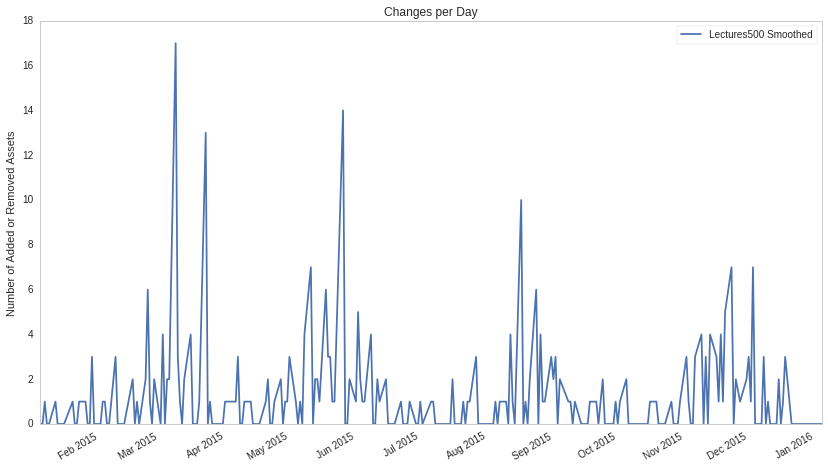

In [8]:


Lectures500 = AtLeastN(inputs=[Lectures500],
                       window_length=21,
                       N=16,)

res_smoothed = run_pipeline(Pipeline(columns={'Lectures500 Smoothed' : Lectures500}), 
                            '2015-01-01',
                            '2016-01-01')
res_smoothed = res_smoothed.unstack().fillna(False)

plot_daily_turnover(res_smoothed)
print_daily_turnover_stats(res_smoothed)

Looking at the metrics, we can see that the smoothed universe has a lower turnover than the original Lectures500. Since this is a good characteristic, we will add this logic to the universe.

NB: Smoothing can also be accomplished by downsampling.

##QTradableStocksUS

Although the Lectures500 is a decent universe, we highly recommend that you use the QTradableStocksUS when designing your algorithms.

The QTradableStocksUS is defined using the following limits:

* Market cap: over \$500M: This restriction eliminates many undiversifiable risks like low liquidity and difficulty in shorting.
* Dollar volume: It is important that stocks in our universe be relatively easy to trade when entering and exiting positions. The QTradableStocksUS manages that by including only stocks that have median daily dollar volume of \$2.5m or more over the trailing 200 days.
* Prior day's close: If a stock's price is lower than \$5, the bid-ask spread becomes larger relative to the price, and the transaction cost becomes too high.
200 days of price and volume: If a stock has missing data for the previous 200 days, the company is excluded. This targets stocks with trading halts, IPOs, and other situations that make them harder to assess.
* Primary/Common share: The QTradableStocksUS chooses a single share class for each company. The criteria is to find the common share with the most dollar volume.
ADRs, Limited Partnerships: QTradableStocksUS excludes ADRs and LPs.
    
and can be implemented in a single line of code.